In [ ]:
import pyvo as vo
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
from astropy.io import fits
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
import pandas as pd


In [ ]:
%matplotlib inline


# Extracting a galaxy through the WISE image service

##  For NGC 7793 

In [ ]:
# using the website that Irsa.ipac relocates you that has a full explanationm of all the code you need
#using NGC 5128: ra= 201.365	dec= -43.019
#SWITCHED it to NGC 7793 ra= 359.45700000000016 dec= -32.592000000000013

#define coordinates	
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
print(pos)

In [ ]:
# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")


In [ ]:
#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table

In [ ]:
im_table.to_table().colnames

In [ ]:
im_table.to_table()['sia_url']

In [ ]:
im_table.to_table()['sia_bp_id']
# i believe this gives us the different bandpasses that you can view the image in. 

In [ ]:
for i in range(len(im_table)):
    print(im_table[i])

In [ ]:
#search for the image in the W3 band image
# using a for loop i assume because it may be printed multiple times maybe?
# i printed it above, it could just be because the ID of the one object is printed 4 times due to there being 4 bandpasses but if you define it at W3 not sure why this is all necessary

for i in range(len(im_table)):
    if im_table[i]['sia_bp_id'] == 'W1':
        break
print(im_table[i].getdataurl())
# ahh yes, so the it runs over the "i" in the dataset until it finds W3 and then stops 
# so using "break" makes the for loop stop after it finds the ID of the object inside of W3
# this is prolly very useful if i am looking for multiple objects.

In [ ]:
#Download the image and open it in Astropy
fname = download_file(im_table[i].getdataurl(), cache=True)
image1= fits.open(fname)
image= image1[0].data
plt.imshow(image, origin = 'lower', vmax = 50)
#plt.xlim(3000,4000)
#plt.ylim(3700,4100)

In [ ]:
#extract a cutout and plot it
wcs = WCS(image1[0].header)
print(image1[0].header)
wcs


In [ ]:
#cuting out the image of the galaxy apart from the rest of the background.
cutout = Cutout2D(image, pos, (400,400), wcs=wcs)
wcs = cutout.wcs

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection = wcs)

#vmax at 4000 gives you the (bulge maybe?) right in the center of it
ax.imshow(cutout.data, origin='lower', vmax = 50)

ax.scatter(ra, dec, transform= ax.get_transform('fk5'), facecolor= 'None', s=3000, edgecolor = 'red', alpha = 1)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#Axis. get_transform() function in axis module of matplotlib library is used to get the "Transform instance used by this artist"

## For NGC 5128


In [ ]:
# using the website that Irsa.ipac relocates you that has a full explanationm of all the code you need
#using NGC 5128: ra= 201.365	dec= -43.019
#SWITCHED it to NGC 7793 ra= 359.45700000000016 dec= -32.592000000000013

#define coordinates	
ra= 201.365	
dec= -43.019

pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
#print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table


im_table.to_table().colnames
im_table.to_table()['sia_url']
im_table.to_table()['sia_bp_id'] # i believe this gives us the different bandpasses that you can view the image in. 


for i in range(len(im_table)):
    print(im_table[i])

    #search for the image in the W3 band image

for i in range(len(im_table)):
    if im_table[i]['sia_bp_id'] == 'W1':
        break
print(im_table[i].getdataurl())


#Download the image and open it in Astropy
fname = download_file(im_table[i].getdataurl(), cache=True)
image1= fits.open(fname)
image= image1[0].data
plt.imshow(image, origin = 'lower', vmax = 50)
#plt.xlim(3000,4000)
#plt.ylim(3700,4100)

#extract a cutout and plot it
wcs = WCS(image1[0].header)
print(image1[0].header)
wcs


#cuting out the image of the galaxy apart from the rest of the background.
cutout = Cutout2D(image, pos, (400,400), wcs=wcs)
wcs = cutout.wcs




In [ ]:
# plotting the image
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection = wcs)

#vmax at 4000 gives you the (bulge maybe?) right in the center of it
ax.imshow(cutout.data, origin='lower', vmax = 1000)

ax.scatter(ra, dec, transform= ax.get_transform('fk5'), facecolor= 'None', s=3000, edgecolor = 'red', alpha = 1)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#Axis. get_transform() function in axis module of matplotlib library is used to get the "Transform instance used by this artist"

# Exploring the downloadable FITS provided by the website 
to understand the properties of the image

In [ ]:
# looking at the WISE specific fits
hdul = fits.open('../Data/image_WISE-Band-1.fits')
hdul.info()

In [ ]:
hdr = fits.getheader('../Data/image_WISE-Band-1.fits')
hdr
#the units are in units of intensity "DN"

In [ ]:
#opening the image in a way similar to astroimagej
# for single aperture
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(230,230,50)] #and , (180,340,50)

#create aperture objects
aperture = [CircularAperture((x,y),r) for (x,y,r) in ROI]


#perform aperture photometry
photo_table = aperture_photometry(phdul, aperture)
print(photo_table)
#results
for i, aperture in  enumerate(aperture):
    flux = photo_table['aperture_sum_0'][i]
print(flux)
hdul.close()

In [ ]:
# for multiple apertures
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(220,220,100), (186,341,11)] #and , (180,340,50)

#results
for i, (x,y,r) in  enumerate(ROI):
   #create aperture objects 
    aperture = CircularAperture((x,y),r)
   #perform aperture photometry
    photo_table = aperture_photometry(phdul, aperture)
    #print(photo_table)
    flux = photo_table['aperture_sum'][0]
    print(f"Region {i+1}: Center=({x}, {y}), Radius={r}")
    print(f"Flux: {flux}")

#visualizing the apertures
for x,y,r in ROI:
    aperture = CircularAperture((x,y),r)
    aperture.plot(color='red', lw = 1.5)


hdul.close()
    

In [ ]:
#code for creating a background ring. also need to retrieve the source-sky uncertainty? leave that for later for now

In [ ]:
#converting vega magnitudesto source flux density for sources with constant power-law spectra: Fv proportional to V^not
#apparent magnitude of vega is .03  and absolute mag is .6
#mvega = .03
#flx_dens_jy = 309.54*(10**(mvega/2.5)


# Flux conversion

In [ ]:
#Converting counts in DN to flux density units
#Instrumental Zero Point Magnitude for WISE Source Photometry in the W1 Band is 20.73
#print(phdul)

#Confused cuz I am not sure what the variable is to convert all of the counts to flux


#Calibrated Magnitude
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
counts = flux # or phdul['MEDINT']? which is the median intensity
Mcal = M0instr - 2.5*(np.log10(counts))
#print(Mcal)

#convert Magnitude to Flux
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor
flx_jy = flx_conv_fact * 10**(Mcal/-2.5)
print(flx_jy)



#mvega = .03
#flx_dens_jy = 309.54*(10**(mvega/2.5)


# Multi-aperture photometry code
## USING NGC 7793

In [ ]:
# for multiple apertures while putting in the flux conversion
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(220, 220, 100, 135, 200), (186, 341, 10, 17, 25)] # (x, y, radius around target, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, (x, y, r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(phdul, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
print(display_data)

#visualizing the apertures
for x, y, r, annulus_inner, annulus_outer in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)


hdul.close()

    

# just in case
below I pasted in the earlier code in case something goes wrong

In [ ]:
# for multiple apertures while putting in the flux conversion
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(220, 220, 100), (186, 341, 11)] # (x, y, r, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]

#results
for i, (x, y, r) in  enumerate(ROI):
# For the Target
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
   
    #converting counts to flux
    M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
    Mcal = M0instr - 2.5*(np.log10(target_counts))

    #convert Magnitude to Flux
    flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor
    flx_jy = flx_conv_fact * 10**(Mcal/-2.5)

    
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Flux (Jy)': flx_jy})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
print(display_data)

#visualizing the apertures
for x,y,r in ROI:
    aperture = CircularAperture((x,y),r)
    aperture.plot(color='red', lw = 1.5)


hdul.close()

# Doing multiple apertures on all Wavelengths and all the little dots
need to start on W4 and then work back in resolution and wavelength

doing this for NGC 7793

## For Band W4

In [ ]:
# starting on W4
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
phdul = hdul[0].data
plt.imshow(phdul, vmax = 152, origin='lower')


#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(225, 245, 12, 40, 60), (219, 221, 12, 40, 60), (320, 185, 12, 40, 60), (295, 245,12, 40, 60)] # (x, y, radius around target, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, (x, y, r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(phdul, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for x, y, r, annulus_inner, annulus_outer in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)


hdul.close()
display_data


## For Band W3

In [ ]:

hdul = fits.open('../Data/imageNGC7793_WISE-Band-3.fits')# for band W3
phdul = hdul[0].data
plt.imshow(phdul, vmax = 575, origin='lower')


#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(225, 245, 12, 40, 60), (219, 221, 12, 40, 60), (320, 185, 12, 40, 60), (295, 245,12, 40, 60)] # (x, y, radius around target, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, (x, y, r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(phdul, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for x, y, r, annulus_inner, annulus_outer in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)


hdul.close()
display_data

## For Band W2

In [ ]:
hdul = fits.open('../Data/image_WISE-Band-2.fits')# for band W2
phdul = hdul[0].data
plt.imshow(phdul, vmax = 25, origin='lower')


#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(225, 245, 12, 40, 60), (219, 221, 12, 40, 60), (320, 185, 12, 40, 60), (295, 245,12, 40, 60)] # (x, y, radius around target, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, (x, y, r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(phdul, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for x, y, r, annulus_inner, annulus_outer in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)


hdul.close()
display_data

## For Band W1

In [ ]:
hdul = fits.open('../Data/image_WISE-Band-1.fits')# for band W2
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')


#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(225, 245, 12, 40, 60), (219, 221, 12, 40, 60), (320, 185, 12, 40, 60), (295, 245,12, 40, 60)] # (x, y, radius around target, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, (x, y, r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(phdul, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for x, y, r, annulus_inner, annulus_outer in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)


hdul.close()
display_data

**Original code for everything aperture related**

In [ ]:
#For W1
# for multiple apertures while putting in the flux conversion
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(220, 220, 100, 135, 200), (186, 341, 10, 17, 25)] # (x, y, radius around target, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, (x, y, r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(phdul, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)


#visualizing the apertures
for x, y, r, annulus_inner, annulus_outer in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)


hdul.close()
display_data


# Finding the FWHM of sources in the W4 band

also using NGC 7793

In [ ]:
from scipy.optimize import curve_fit
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std, sigma_clipped_stats

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
# look at A) Research with Roy/Code/Lab4code(2and3)-Copy1.ipynb

In [ ]:
# identify sources in the image
#DOAstarfinder vs IRAFstarfinder. DOA is prolly better. look at the doc you created titled FWHM for more info
# starting on W4
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
phdul = hdul[0].data

plt.imshow(phdul, vmax = 152, origin='lower')


mean, median, std = sigma_clipped_stats(phdul, sigma=3.0)  
print((mean, median, std))

hdul.close()


In [ ]:
# subtract the background and find FWHM of sources at a certain threshold
#started at fwhm= 3 and threshold = 5
daofind = DAOStarFinder(fwhm=3.0, threshold=.7*std) # find the stars in the image that have FWHMs of around 3 pixels and have peaks approximately 5-sigma above the background. 
sources = daofind(phdul - median)  
print(type(sources))
# will likely run into iissues in the code below
for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output
sources.pprint(max_width=3000)  

#likely the flux labeled in this is not converted!

hdul.close()

In [ ]:
# plot the image with marked locations of all the sources it detected.
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=8.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(phdul, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)

In [ ]:

amp = sources['peak']

#define the 2d gaussian. look at your docs more more of an xpplanation, but sigma_x and sigma_y are just the std's of the x and y centroids. 
## generally good to make a guess of around 3 pixels 
### xo and yo are the exact same as x and y so you don't need to make another guess with them.

def gaussian2d(xy, amp, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)

    #break up 'g' into smaller components a, b, and c
    a = (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
    b = -( (np.sin(2*theta)) / (4*sigma_x**2) ) + ( (np.sin(2*theta)) / (4*sigma_y**2) )
    c = ((np.sin(theta)**2) / (2*sigma_x**2)) + ((np.cos(theta)**2) / (2*sigma_y**2))
    
    #put them all back into g
    g = offset + amp * np.exp( - (a * ((x-xo)**2) + (2 * b * (x-xo)*(y-yo)) + (c *((y-yo)**2) ) ))
    return g.ravel()

# if something goes wrong in the code, it is more than likely due to the gaussian function you defined.
# you may need to make an initial guess for xo and yo if it doesn't work. but leave their initial guesses empty for now.

In [ ]:
#Fit the gaussian to the region around each source
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
image_data = hdul[0].data
#print(f"Image data shape: {image_data.shape}")
fwhms = []
aperture_radius = 8
print(sources['xcentroid'].shape)

#loop over each source to fit the gaussian and determine the fwhm
for i in range(len(sources)):
    x, y = float(sources['xcentroid'][i]), float(sources['ycentroid'][i])
    #print(f"Source {i+1}: (x, y) = ({x}, {y})")

    #define the bounding box around the source so you can make a mesh grid. 
    ##by subtracting the aperture radius from the maximum of the centroid of x (meaning the center of the aperture in the x axis) it allows you to get the minimum distance from the center needed. and vice versa for the maximum
    ##the reason you use the image_data.shape[1] is because you need to know the shape and size of the image so that the gaussian does not fit to sources outside the image.
    ## in doing all of this, you ensure that the box around the source stays within the image which is especially useful for sources at the edge of the image!
    x_min = max(int(x)- aperture_radius, 0)
    x_max = min(int(x) + aperture_radius, image_data.shape[1])
    y_min = max(int(y) - aperture_radius, 0)
    y_max = min(int(y)+ aperture_radius, image_data.shape[0])

    #extract the region relevant for fitting
    region = phdul[y_min:y_max, x_min:x_max]
    
    #create meshgrid for the region
    x_region = np.linspace(x_min, x_max - 1, x_max - x_min)
    y_region = np.linspace(y_min, y_max - 1, y_max - y_min)
    x_region, y_region = np.meshgrid(x_region, y_region)

    #line of debugging code for the bounding box etc
    #print(f"Source {i+1}: (x, y) = ({x}, {y})")
    #print(f"Bounding box: x_min = {x_min}, x_max = {x_max}, y_min = {y_min}, y_max = {y_max}")
    


    # initial guesses for the parameters of the 2d gaussian and curve_fit. using np.median because you want the middle of the aperture.
    initial_guess = (sources['peak'][i], x, y, 3, 3, 0, np.median(region))
    # Debugging print statement to check the initial guess
    #print(f"Initial guess for source at ({x}, {y}): {initial_guess}")


    #fit the gaussian model
    try:
        optimal_parameters, covariance_parameters = curve_fit(gaussian2d, (x_region, y_region), region.ravel(), p0 = initial_guess )
    except RuntimeError:
            print(f" Could not fit gaussian for source at ({x}, {y})")
            continue
    #extract the sigmas from the optimal parameters
    sigma_x, sigma_y = optimal_parameters[3], optimal_parameters[4]
    #print(sigma_x,sigma_y)
    #calculate the FWHM
    fwhm_y = 2.3548 * sigma_y
    fwhm_x = 2.3548 * sigma_x
    fwhm = np.mean([fwhm_x, fwhm_y])
    fwhms.append(fwhm)

    print(f"Source at ({x}, {y}): FWHM = {fwhm: .2f} pixels")

fwhms






# for visualizing the aperutrues, i wonder if there is a way to loop over all of the radii and then plot it.

In [ ]:
#visualizing the apertures on the image and using the FWHMs for aperture photometry

#define aperture_radii based on the FWHM for each source
aperture_radii = [1* fwhm for fwhm in fwhms]

# initialize figure and axes for plotting:
fig, ax = plt.subplots(figsize=(8, 8))
norm = ImageNormalize(stretch=SqrtStretch())

# plot the image
ax.imshow(image_data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')

# plot apertures for each source

for i, source in enumerate(sources):
    position = np.transpose((sources['xcentroid'][i], sources['ycentroid'][i])) #may not need the transpose part but we'll see
    aperture_radius = aperture_radii[i]
    aperture = CircularAperture(position, r=aperture_radius)
    phot_table = aperture_photometry(image_data, aperture)
    aperture.plot(ax=ax, color='blue', lw=1.5, alpha=0.5)

ax.set_title('Apertures with FWHM for Sources')
plt.show()


# example of  Determining the extraction region for aperture photometry
   #the 1.5 is there because you want to ensure that it encompasses all of the sources light and flux but also does not capture the background. 
   ## it makes sure you cover the source adequately, so you can def change i if you think you encompass too much or too little.


# Finding where all of Anthony's x-ray sources are 

Using NGC7793

In [ ]:
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

In [ ]:
from astroML.crossmatch import crossmatch_angular
#cross match the catalogs
#max_radius = 2/3600 (2 arcseconds) # may need to change this to one-two arcmin based on the wise photos: (60/3600) or 120/3600. see how they increase or decrease.
#or actually just do the merge thing
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources
#lowkey i think that worked



In [ ]:
# just want NGC 7793
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
sources_7793



## plotting the sources on the image of NGC 7793


I wonder if I'll need the "theta" from the huge csv file. or what that even means. cuz i feel like that might be useful for the gaussian maybe

In [ ]:
#plotting just the sources
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
hdr = fits.getheader('../Data/imageNGC7793_WISE-Band-4.fits')
wcs = WCS(hdr)

image_data = hdul[0].data

#plot the image
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(image_data, stretch=SqrtStretch())
ax.imshow(image_data, cmap= 'gray', norm=norm)

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra,dec)

#create circular apertures for each source
apertures = [CircularAperture((x, y), r=5) for x, y in zip(*positions)]

#plot each aperture
for aperture in apertures:
    aperture.plot(ax=ax, color='blue', lw=1.5, alpha=0.5)

plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()



hdul.close()

## Performing Aperture photometry on all of the xray sources for NGC 7793
Must plot them with the same (uniform) FWHM. so i think i will just use the one in the very center (13.73 pixels)

maybe determine what size it should be by finding every single point source in the image and calculating the FWHM of it and then just using the average of that. and doing this for every image.

In [ ]:
#plotting just the sources
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
hdr = fits.getheader('../Data/imageNGC7793_WISE-Band-4.fits')
wcs = WCS(hdr)

image_data = hdul[0].data

#plot the image
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(image_data, stretch=SqrtStretch())
ax.imshow(image_data, cmap= 'gray', norm=norm)

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra,dec)

#create circular apertures for each source
apertures = [CircularAperture((x, y), r=11) for x, y in zip(*positions)]

#plot each aperture
for aperture in apertures:
    aperture.plot(ax=ax, color='blue', lw=1.5, alpha=0.5)

plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()

In [ ]:
print(image_data[0])

In [ ]:
# starting on W4 ALSO USING THE CODE ABOVE THIS CELL
#plotting just the sources
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
hdr = fits.getheader('../Data/imageNGC7793_WISE-Band-4.fits')
wcs = WCS(hdr)

image_data = hdul[0].data

#plot the image
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(image_data, stretch=SqrtStretch())
ax.imshow(image_data, cmap= 'gray', norm=norm)

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra,dec)

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 8, 13, 20) for x,y in zip(*positions) ] # (x, y, radius around target, inner r, outer r)    36.3636, 50.90909)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(image_data, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(image_data, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for ((x, y), r, annulus_inner, annulus_outer) in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()

hdul.close()
display_data

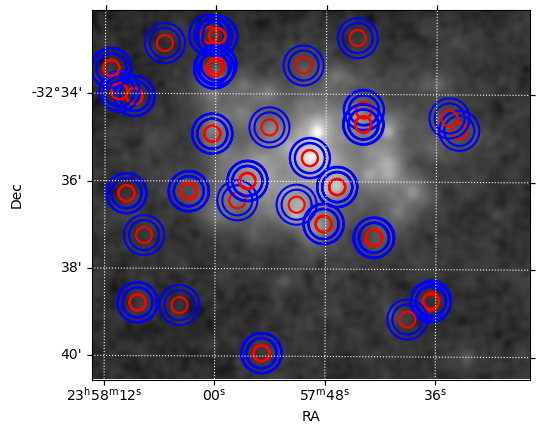

,Region,X,Y,Radius,Annulus_Inner_Radius,Annulus_Outer_Radius,Net Flux (Jy),Flag,aperture_sum,tot_bg
2,3,366.350472,247.742249,8,15,20,0.000006,Valid,29909.637217,1.607576
3,4,356.612296,260.118440,8,15,20,0.000111,Valid,29908.908776,1.607432
4,5,337.807192,76.341836,8,15,20,0.000138,Valid,29861.010505,1.604831
5,6,281.479026,141.357579,8,15,20,0.000696,Valid,29924.011295,1.607659
8,9,271.082657,253.923524,8,15,20,0.001738,Valid,30112.775496,1.616763
10,11,244.297491,191.510016,8,15,20,0.009923,Valid,30333.933138,1.620464
12,13,230.602584,154.746395,8,15,20,0.003404,Valid,30085.476212,1.613629
21,22,169.095810,25.994373,8,15,20,0.000042,Valid,29869.952603,1.605407
25,26,154.726349,197.462405,8,15,20,0.000754,Valid,30141.597380,1.619296
29,30,124.664378,342.297229,8,15,20,0.000671,Valid,29865.111323,1.604518


In [189]:
# starting on W4 ALSO USING THE CODE ABOVE THIS CELL

###### MAKE SURE THAT YOU CHANGE THE CONVERSION FACTORS FOR THE FLUX CONVERSION FOR EACH BAND WAVELENGTH

#plotting just the sources
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
hdr = fits.getheader('../Data/imageNGC7793_WISE-Band-4.fits')
wcs = WCS(hdr)

image_data = hdul[0].data

#plot the image
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(image_data, stretch=SqrtStretch())
ax.imshow(image_data, cmap= 'gray', norm=norm)

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra, dec)
positions = np.array(list(zip(positions[0], positions[1])))





#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 8, 15, 20) for x,y in positions ] # (x, y, radius around target, inner r, outer r)    36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr =  12.98 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  8.363 # the  Zero Magnitude Flux Density conversion factor 

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask


# check for overlap and perform aperture photometry
for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
    overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
    non_overlapping_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x,y), r)

    for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
        if i != j: # ensures that a source is not compared to itself! wow
            distance = dist((x, y) , (x2, y2)) 
            if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                if overlap_percent > 1:
                    overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                    break
                else: 
                    overlap_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x2,y2), r2)
                    non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                    # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                    # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                
    if overlap:
        #flag the sources that overlap
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                      'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
    else: #perform all the aperture photometry stuff
        # For the Target object in the little circle
        #define the target aperture objects 
        target_aperture = CircularAperture((x,y),r,)
    
        #perform aperture photometry on target
        # also now apply the masked data
        #masked_data = image_data * non_overlapping_mask
        target_photo_table = aperture_photometry(image_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
        target_counts = target_photo_table['aperture_sum'][0]

        if target_counts<= 0: # 
            target_flux # avoid taking the log of zero or negative value
        else:
                #counts to flux
            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
            #calculate area of annulus
        target_area = target_aperture.area



        # For the Background Annuli of outside of the Target
        #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
        annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

        #perform aperture photometry on annuli
        annulus_photo_table = aperture_photometry(image_data, annulus_aperture)
        annulus_counts = annulus_photo_table['aperture_sum'][0]
    
        if annulus_counts <= 0:
            annulus_flux = 0  # Avoid taking log of zero or negative value
        else:
            #counts to flux
            Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
            annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

        #calculate area of annulus
        annulus_area = annulus_aperture.area
       # print(annulus_area)


        # do the calculations for including a Background aperture
    
        #Calculating the net flux:
     #calculate the mean background per pixel
        bg_perpixel = annulus_flux/annulus_area

        #calculate the total background in the target aperture
        tot_bg = bg_perpixel * target_area

        #Subtract background from the target flux
        net_flx = target_flux - tot_bg
    
        #   Append the result as a dictionary to the list named 'rows'
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                 'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux', 'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg})  #will prolly have to change the name of the Flux here!!!
    

    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5)
        annulus_aperture.plot(color = 'blue', lw = 1.5)

####if you want to see all of them use the code below:
#for ((x, y), r, annulus_inner, annulus_outer) in ROI:
    #target_apertureplt = CircularAperture((x,y),r)
   # annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
   # target_apertureplt.plot(color='red', lw = 1.5)
   # annulus_apertureplt.plot(color='red', lw = 1.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()

hdul.close()
display_data.loc[display_data['Flag']== 'Valid']

In [ ]:
from scipy.spatial import KDTree

Source 1:
  Overlap: True
  Image Data Shape: (369, 437)
  Mask Shape: (369, 437)
  Mask Type: bool
  Non-zero mask elements: 150
Source 2:
  Overlap: True
  Image Data Shape: (369, 437)
  Mask Shape: (369, 437)
  Mask Type: bool
  Non-zero mask elements: 380
Source 3:
  Overlap: False
  Image Data Shape: (369, 437)
  Mask Shape: (369, 437)
  Mask Type: bool
  Non-zero mask elements: 320
  Target Counts: 46346.02371060646
  Annulus Counts: 127578.43932648696
  Net Flux: -0.5482148986666426
Source 4:
  Overlap: False
  Image Data Shape: (369, 437)
  Mask Shape: (369, 437)
  Mask Type: bool
  Non-zero mask elements: 316
  Target Counts: 46007.66566195557
  Annulus Counts: 127571.89282172485
  Net Flux: -0.5662450049939123
Source 5:
  Overlap: True
  Image Data Shape: (369, 437)
  Mask Shape: (369, 437)
  Mask Type: bool
  Non-zero mask elements: 381
Source 6:
  Overlap: True
  Image Data Shape: (369, 437)
  Mask Shape: (369, 437)
  Mask Type: bool
  Non-zero mask elements: 381
Source 7:


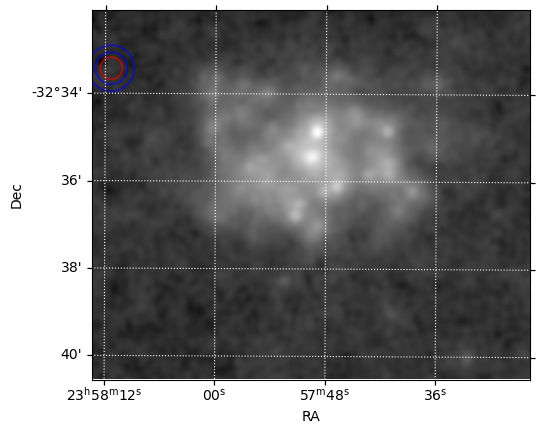

,Region,X,Y,Radius,Annulus_Inner_Radius,Annulus_Outer_Radius,Net Flux (Jy),Flag,aperture_sum,tot_bg
45,46,19.014239,310.340772,11,16,23,0.116688,Valid,54825.993669,2.830098


In [190]:
# starting on W4 ALSO USING THE CODE ABOVE THIS CELL

###### MAKE SURE THAT YOU CHANGE THE CONVERSION FACTORS FOR THE FLUX CONVERSION FOR EACH BAND WAVELENGTH

#plotting just the sources
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
hdr = fits.getheader('../Data/imageNGC7793_WISE-Band-4.fits')
wcs = WCS(hdr)

image_data = hdul[0].data

#plot the image
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(image_data, stretch=SqrtStretch())
ax.imshow(image_data, cmap= 'gray', norm=norm)

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra,dec)
positions1 = np.array(list(zip(positions[0], positions[1])))

#define the distance threshold for the KDTree grouping (in pixels)
distance_threshold = 1

#build the KDTree for efficient grouping
tree = KDTree(positions1)

#query the KDTree to find points within the defined radius of dist threshold and group them together
groups = tree.query_ball_tree(tree, r=distance_threshold)

# consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
unique_groups = []
seen = set()
for group in groups:
    group = tuple(sorted(group))
    if group not in seen:
        seen.add(group)
        unique_groups.append(group)

# for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
#represents the consolidated postion of potentially multiple detections of one source.
grouped_positions = [positions1[list(group)].mean(axis=0) for group in unique_groups]


#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 11, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)    36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr =  12.98 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  8.363 # the  Zero Magnitude Flux Density conversion factor 

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X - center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask.astype(bool)


# check for overlap and perform aperture photometry
for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
    overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
    non_overlapping_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x,y), r)

    for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
        if i != j: # ensures that a source is not compared to itself! wow
            distance = dist((x, y) , (x2, y2)) 
            if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                if overlap_percent > .5:
                    overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                    break
                else: 
                    overlap_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x2,y2), r2)
                    non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                    # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                    # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
    # Debugging statements
    print(f"Source {i + 1}:")
    print("  Overlap:", overlap)
    print("  Image Data Shape:", image_data.shape)
    print("  Mask Shape:", non_overlapping_mask.shape)
    print("  Mask Type:", non_overlapping_mask.dtype)
    print("  Non-zero mask elements:", np.count_nonzero(non_overlapping_mask))

    if overlap:
        #flag the sources that overlap
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                      'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
    else: 
        if np.count_nonzero(non_overlapping_mask) == 0:
            print("  Warning: Non-overlapping mask has zero non-zero elements.")
            rows.append({'Region': i + 1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                         'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'No Data'})
            continue

        
        #perform all the aperture photometry stuff
        # For the Target object in the little circle
        #define the target aperture objects 
        target_aperture = CircularAperture((x,y),r,)
        #apply the mask to the data
        masked_data = np.where(non_overlapping_mask, image_data, 0)
        #perform aperture photometry on target
        target_photo_table = aperture_photometry(masked_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
        target_counts = target_photo_table['aperture_sum'][0]

        if target_counts <= 0 or np.isnan(target_counts): # 
            target_flux # avoid taking the log of zero or negative value
        else:
                #counts to flux
            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
            #calculate area of annulus
        target_area = target_aperture.area



        # For the Background Annuli of outside of the Target
        #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
        annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

        #perform aperture photometry on annuli
        annulus_photo_table = aperture_photometry(image_data, annulus_aperture)
        annulus_counts = annulus_photo_table['aperture_sum'][0]
    
        if annulus_counts <= 0 or np.isnan(annulus_counts):
            annulus_flux = 0  # Avoid taking log of zero or negative value
        else:
            #counts to flux
            Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
            annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

        #calculate area of annulus
        annulus_area = annulus_aperture.area
       # print(annulus_area)


        # do the calculations for including a Background aperture
    
        #Calculating the net flux:
     #calculate the mean background per pixel
        bg_perpixel = annulus_flux/annulus_area

        #calculate the total background in the target aperture
        tot_bg = bg_perpixel * target_area

        #Subtract background from the target flux
        net_flx = target_flux - tot_bg
        
        # Additional Debugging for Flux Values
        print("  Target Counts:", target_counts)
        print("  Annulus Counts:", annulus_counts)
        print("  Net Flux:", net_flx)

        
        #   Append the result as a dictionary to the list named 'rows'
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                 'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux', 'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg})  #will prolly have to change the name of the Flux here!!!
    #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting

    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)

####if you want to see all of them use the code below:
#for ((x, y), r, annulus_inner, annulus_outer) in ROI:
    #target_apertureplt = CircularAperture((x,y),r)
   # annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
   # target_apertureplt.plot(color='red', lw = 1.5)
   # annulus_apertureplt.plot(color='red', lw = 1.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()

hdul.close()


display(display_data.loc[display_data['Flag']== 'Valid'])
pd.set_option("display.max_rows", None)
#display_data


In [ ]:
#iterating over all of the wavelengths

#query the database and pull all of the wavelengths for NGC 7793
# using the website that Irsa.ipac relocates you that has a full explanationm of all the code you need
#using NGC 5128: ra= 201.365	dec= -43.019
#SWITCHED it to NGC 7793 ra= 359.45700000000016 dec= -32.592000000000013

#define coordinates	make it possible to run a list over this with all of the ra and decs
ra= 359.45700000000016
dec= -32.592000000000013

pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
#print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)

#im_table.to_table().colnames
#im_table.to_table()['sia_url']
#im_table.to_table()['sia_bp_id'] # i believe this gives us the different bandpasses that you can view the image in. 
for i in range(len(im_table)):
    print(im_table[i])


#convert it to an astropy table and sort the images bandpass id in ascending order
#im_table_sorted = im_table.to_table()
#im_table_sorted.sort('sia_bp_id')

#now reverse it so it is w4,w3,w2,w1
#im_table_sorted = im_table_sorted[::-1]

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
#flux_conversions
#currently outputs as w4,w1,w2,w3. so index is 0.1.2.3 i want the index to be 0.3.2.1

for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image= image1[0].data
        #print(data)

        #extract a cutout and plot it
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image, pos, (400,400), wcs=wcs)
        wcs = cutout.wcs
    
        # plotting the image
        fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        ax.imshow(cutout.data, cmap= 'gray', norm=norm)

        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()

        #now inputting the aperture photometry part








display(display_data.loc[display_data['Flag']== 'Valid'])
pd.set_option("display.max_rows", None)





### Dont think i need the code below in this cell

In [ ]:

#Download the image and open it in Astropy
fname = download_file(im_table[i].getdataurl(), cache=True)
image1= fits.open(fname)
image= image1[0].data
#plt.imshow(image, origin = 'lower', vmax = 50)
#plt.xlim(3000,4000)
#plt.ylim(3700,4100)

#extract a cutout and plot it
wcs = WCS(image1[0].header)
#print(image1[0].header)
wcs


#cuting out the image of the galaxy apart from the rest of the background.
cutout = Cutout2D(image, pos, (400,400), wcs=wcs)
wcs = cutout.wcs

# plotting the image
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
ax.imshow(cutout.data, cmap= 'gray', norm=norm)

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#Axis. get_transform() function in axis module of matplotlib library is used to get the "Transform instance used by this artist"


for i in range(len(im_table)):
    print(f'Band W{i+1}: ')
    data = im_table[i].getdataurl()
    #Download the image and open it in Astropy
    fname = download_file(data, cache=True)
    image1= fits.open(fname)
    image= image1[0].data
    #print(data)

    #extract a cutout and plot it
    wcs = WCS(image1[0].header)
    #cuting out the image of the galaxy apart from the rest of the background.
    cutout = Cutout2D(image, pos, (400,400), wcs=wcs)
    wcs = cutout.wcs
    
    # plotting the image
    fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
    norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
    ax.imshow(cutout.data, cmap= 'gray', norm=norm)

    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')
    



In [ ]:
#Fit the gaussian to the region around each source
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
image_data = hdul[0].data
#print(f"Image data shape: {image_data.shape}")
fwhms = []
aperture_radius = 8
#print(sources['xcentroid'].shape)

#loop over each source to fit the gaussian and determine the fwhm
for i in range(len(sources_7793)):
    x, y = float(sources_7793['RA'][i]), float(sources_7793['Dec'][i])
    print(f"Source {i+1}: (x, y) = ({x}, {y})")

    #define the bounding box around the source so you can make a mesh grid. 
    ##by subtracting the aperture radius from the maximum of the centroid of x (meaning the center of the aperture in the x axis) it allows you to get the minimum distance from the center needed. and vice versa for the maximum
    ##the reason you use the image_data.shape[1] is because you need to know the shape and size of the image so that the gaussian does not fit to sources outside the image.
    ## in doing all of this, you ensure that the box around the source stays within the image which is especially useful for sources at the edge of the image!
    x_min = max(int(x)- aperture_radius, 0)
    x_max = min(int(x) + aperture_radius, image_data.shape[1])
    y_min = max(int(y) - aperture_radius, 0)
    y_max = min(int(y)+ aperture_radius, image_data.shape[0])

    #extract the region relevant for fitting
    region = phdul[y_min:y_max, x_min:x_max]
    
    #create meshgrid for the region
    x_region = np.linspace(x_min, x_max - 1, x_max - x_min)
    y_region = np.linspace(y_min, y_max - 1, y_max - y_min)
    x_region, y_region = np.meshgrid(x_region, y_region)

    #line of debugging code for the bounding box etc
    #print(f"Source {i+1}: (x, y) = ({x}, {y})")
    #print(f"Bounding box: x_min = {x_min}, x_max = {x_max}, y_min = {y_min}, y_max = {y_max}")
    
# need to change the value of sources['peak'][i] so trying to find a way around that.

    # initial guesses for the parameters of the 2d gaussian and curve_fit. using np.median because you want the middle of the aperture.
    initial_guess = (sources['peak'][i], x, y, 1, 1, 0, np.median(region))
    # Debugging print statement to check the initial guess
    print(f"Initial guess for source at ({x}, {y}): {initial_guess}")


    #fit the gaussian model
    try:
        optimal_parameters, covariance_parameters = curve_fit(gaussian2d, (x_region, y_region), region.ravel(), p0 = initial_guess )
    except RuntimeError:
            print(f" Could not fit gaussian for source at ({x}, {y})")
            continue
    #extract the sigmas from the optimal parameters
    sigma_x, sigma_y = optimal_parameters[3], optimal_parameters[4]
    print(sigma_x,sigma_y)
    #calculate the FWHM
    fwhm_y = 2.3548 * sigma_y
    fwhm_x = 2.3548 * sigma_x
    fwhm = np.mean([fwhm_x, fwhm_y])
    fwhms.append(fwhm)

    print(f"Source at ({x}, {y}): FWHM = {fwhm: .2f} pixels")

fwhms


# Putting it all together

scraping through the WISE image set and pulling all 74 galaxies in all four Wavelengths

**Outline**
- pull all of the images and their Wavelengths
- for each galaxy
    - run the aperture photometry for each Band wavelength of the observed galaxy. Starting with the 4th band.

In [ ]:
# Query the image catalog in the WISE database
#define coordinates	make it possible to run a list over this with all of the ra and decs
ra= 359.45700000000016
dec= -32.592000000000013

pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
#print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)

 

#####   constants in every image:

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask


# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }


#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra,dec)
positions = np.array(list(zip(positions[0], positions[1])))

#define the distance threshold for the KDTree grouping (in pixels)
distance_threshold = 1

#build the KDTree for efficient grouping
tree = KDTree(positions)

#query the KDTree to find points within the defined radius of dist threshold and group them together
groups = tree.query_ball_tree(tree, r=distance_threshold)

# consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
unique_groups = []
seen = set()
for group in groups:
    group = tuple(sorted(group))
    if group not in seen:
        seen.add(group)
        unique_groups.append(group)

# for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
#represents the consolidated postion of potentially multiple detections of one source.
grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]


#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 11, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)    36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]




#####  End of constants










##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3. so index is 0.1.2.3 i want the index to be 0.3.2.1
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)

        #extract a cutout and plot it
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (400,400), wcs=wcs)
        wcs = cutout.wcs
    
        # plotting the image
        fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        ax.imshow(cutout.data, cmap= 'gray', norm=norm)

        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()

        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            break
                        else: 
                            overlap_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                        
            if overlap:
                #flag the sources that overlap
                rows.append({'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                            'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
            else: #perform all the aperture photometry stuff
                # For the Target object in the little circle
                #define the target aperture objects 
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                # also now apply the masked data
                masked_data = image_data * non_overlapping_mask
                target_photo_table = aperture_photometry(masked_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
                target_counts = target_photo_table['aperture_sum'][0]

                
                #counts to flux for target aperture
                if band_id in instr_zpmag and band_id in flux_zmfd:
                    M0instr = instr_zpmag[band_id]
                    flx_conv_fact = flux_zmfd[band_id]
                    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                    #calculate area of annulus
                target_area = target_aperture.area



                # For the Background Annuli of outside of the Target
                #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(image_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]

                #Counts to flux for the aperture annuli
                if band_id in instr_zpmag and band_id in flux_zmfd:
                    M0instr = instr_zpmag[band_id]
                    flx_conv_fact = flux_zmfd[band_id]
                    Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

                #calculate area of annulus
                annulus_area = annulus_aperture.area
            # print(annulus_area)


                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
            #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
            
                #   Append the result as a dictionary to the list named 'rows'
                rows.append({'band_id': {band_labels[band_id]}, 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux', 'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting

    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)

####if you want to see all of them use the code below:
#for ((x, y), r, annulus_inner, annulus_outer) in ROI:
    #target_apertureplt = CircularAperture((x,y),r)
   # annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
   # target_apertureplt.plot(color='red', lw = 1.5)
   # annulus_apertureplt.plot(color='red', lw = 1.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()



display(display_data.loc[display_data['Flag']== 'Valid'])
pd.set_option("display.max_rows", None)



